# How Biases in Crowdworkers Affect the Toxicity Prediction
Jiyu Wang

## Motivation
In assignment 2, we analyzed the demographical bias in annotators of the Wikipedia Talk dataset and proposed possible influence of these biases on machine learning projects. I would like to train NLP models on datasets that have different annotation contribution and assess their performance.

First, this topic is related to our course content. It focused on classifying toxic comments. Instead of depending on crowdworkers to label millions of comments, it attempts to use machine learning to label comments which is much more efficient. Second, natural language processing (NLP) has been a popular topic in data science and I would like to use this opportunity to explore this topic. This is interesting from a human-centered perspective since it matters for us to explore better ways to classify comments on the Internet more efficiently and more effectively. I hope to learn not only some basic knowledge and skills about NLP but also some insights on the advantages and limitations of NLP in accomplishing similar tasks.

## Background
Comment toxicity classification has been a popular topic in the field of natural language processing. Predicting toxic comments is helpful in cleaning the Internet environment. The model can be potentially used in various applications. First, it could protect web content viewers by blocking highly toxic comments ([example](https://github.com/conversationai/perspective-hacks/blob/master/comment_filter/README.md)). It keeps meaningful discussions and identifies users that are frequently posting toxic comments. Second, it helps editors and authors to pre-assess the posts ([example](https://github.com/conversationai/perspectiveapi-authorship-demo)). It could provide real-time feedback on the writing content thus potentially yield better output. Third, for admins, it is helpful by auto-checking all contents and deleting toxic comments.

Various models have been utilized in the txocity prediction, including simply K-nearest neighbors model and neural networks (as shown in this [blog](https://medium.com/@nupurbaghel/toxic-comment-classification-f6e075c3487a)). the LSTM (Long Short-term Memory) models belong to the recurrent neural network family and have been widely used in time series analysis and natural language processing. Specifically for comment toxicity prediction, LSTM has been used to predict toxicity scores. It has been proven that LSTM model could successfully achieve good performance in suggesting toxic comments during the  [toxicity prediction competition](https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version).

In assignment 2, we explored the demographical distribution of annotators, in which we inferred differences in annotations from different groups. This phenomenon is well known and inevitable. But, whether these biases will impact further applications on the dataset remains unknown.

Since the annotations of the Wikipedia Talk dataset were performed by crowdworkers, whose demographical distribution is hard to control in a project scope, it is possible that a certain task will recruit more annotators from a certain demographical group. Methods that were designed to alleviate biases such as averaging the scores might not work in this scenario, due to the skewed distribution of the population distribution.

## Research Question
How does the bias in crowdworkers' demographical distribution affect the toxicity prediction? Specifically, will a dataset annotated by mostly females give us different toxicity prediction performance compared to a more balanced dataset or a male-biased dataset? Further questions like "how does the ratio of female annotators affect the model performance?" can be asked later.

I will also extend this research to study other demographical areas, such as first-language groups and age groups, if time permitted.

## Hypothesis
Since our preliminary analysis indicated that females are more likely to label comments as toxic, I hypothesize that higher ratio of female annotators will yield more negative toxicity scores. Similarly, since non-native English speakers tend to label comments as toxic, I expect to observe more negative toxicity scores with higher ratio of non-native annotators.

## Methodology

### Dataset Preparation
The original dataset consists of three files:
- toxicity_annotated_comments.tsv: context and id of 159686 annotated comments
- toxicity_annotations.tsv: annotations of each comment from 10 random workers
- toxicity_worker_demographics.tsv: demographics of workers

All three files are used to create the training set and test set as described below:

#### Merge necessary columns from three files
First, import some necessary libraries and open three raw data files.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

RAW_DATA = 'raw-data'
DATA_PATH = 'data'

annotation_file = 'toxicity_annotations.tsv'
comments_file = 'toxicity_annotated_comments.tsv'
workers_file = 'toxicity_worker_demographics.tsv'

In [2]:
annotation = pd.read_csv(os.path.join(RAW_DATA, annotation_file), sep='\t')
comments = pd.read_csv(os.path.join(RAW_DATA, comments_file), sep='\t')
workers = pd.read_csv(os.path.join(RAW_DATA, workers_file), sep='\t')

Create a dataframe called 'data' which contains all necessary columns from all three files. The comment text and worker gender are joined to the annotation file with respective ids. Specifically, since annotators with unknown gender were labeled as "other" which does not provide information on gender, I only kept the male and female gender annotators in this analysis.

In [3]:
data = annotation[['rev_id', 'worker_id', 'toxicity_score']].merge(comments[['rev_id', 'comment']], on='rev_id').merge(workers[['worker_id','gender']], on='worker_id')
data = data[data['gender'].isin(['female', 'male'])]

#### Split comments into training and test set
The dataset is then splitted into training and test set based on the comment id

In [4]:
train, test = train_test_split(comments['rev_id'], test_size=0.1, random_state=111)
# train set
df = data[data['rev_id'].isin(train)]
# test set
df_test = data[data['rev_id'].isin(test)]

#### Sample from female or male annotators and generate training sets
Basic information on annotators grouped by gender:

In [5]:
females = workers[workers['gender']=='female']['worker_id']
males = workers[workers['gender']=='male']['worker_id']
n_female = len(females)
n_male = len(males)
print("female annotators: "+str(n_female))
print("male annotators: "+str(n_male))

female annotators: 1263
male annotators: 2327


These information is then used to create various training sets.

Female 0 dataset and female 100 dataset are created by filtering all female annotators or all male annotators.

In [6]:
# female only and male only dataset
female100 = df[df['gender']=='female']
female0 = df[df['gender']=='male']

Since there are fewer female annotators than male annotators, the female 50 dataset is created by sampling same number of male annotators and combining with all female annotators.

In [7]:
# female 50% dataset
male50idx = males.sample(n_female, random_state=111)
female50 = df[df['worker_id'].isin(females.append(male50idx))]
len(females.append(male50idx))

2526

The female 25 and female 75 datasets are then created by sampling female annotators or male annotators.

In [8]:
# female 25% dataset
female25idx = females.sample(n_male//3, random_state=111)
female25 = df[df['worker_id'].isin(males.append(female25idx))]
len(males.append(female25idx))

3102

In [9]:
# female 75% dataset
male25idx = males.sample(n_female//3, random_state=111)
female75 = df[df['worker_id'].isin(females.append(male25idx))]
len(females.append(male25idx))

1684

Since each comment was annotated by 10 annotators (less than 10 after we exclude some annotators), I averaged the toxicity scores of each comment to obtain its "real label". All five training sets and the test set are processed in this way. Notes: the gender selection is not processed for test set, since only the real labels are needed to compare with prediction results.

In [10]:
raw_datasets = {'0':female0, '0.25':female25, '0.5':female50, '0.75':female75, '1':female100}
datasets = {}
# take average of all comments
for k, v in raw_datasets.items():
    tscore = v.groupby('rev_id')['toxicity_score'].mean().round(2)
    new = v.drop_duplicates(subset=['rev_id', 'comment'])[['rev_id', 'comment']].join(tscore, on='rev_id', how='left')
    datasets[k] = new
    print(f"female ratio {k}: size {len(new)}")

female ratio 0: size 143681
female ratio 0.25: size 143717
female ratio 0.5: size 143706
female ratio 0.75: size 142581
female ratio 1: size 138368


In [11]:
# test set
tox = data.groupby('rev_id')['toxicity_score'].mean().round(2)
test_set = df_test.drop_duplicates(subset=['rev_id', 'comment'])[['rev_id', 'comment']].join(tox, on='rev_id', how='left')

All generated datasets are saved in the ["data"](data) folder for further analysis.

In [12]:
# save all datasets
for k, v in datasets.items():
    file_name = f"train_female{k}.csv"
    v.to_csv(os.path.join(DATA_PATH, file_name), index=False)
test_set.to_csv(os.path.join(DATA_PATH, 'test.csv'), index=False)

### NLP model training

Several LSTM models are used to accomplish this prediction task. LSTM (Long short-term memory) model is one of the recurrent neural networks widely used for natural language processing and time series etc. The LSTM model implemented with Tensorflow and some necessary functions can be found in [lstm-train.py](lstm-train.py). The training was performed on the kaggle website since it provides free GPUs for deep learning training.

Each training set (female0, female25, female50, female75, and female100) was trained on one LSTM model. The trained model is then used to predict toxicity scores for the test set. The predictions are saved in the ["results"](result) folder.

### Evaluation of predictions

The predictions are then evaluated by two methods.

First, mean-squared-error (MSE) is calculated to assess the overall quality of predictions. The MSE metrics accumulates prediction errors of each comment relative to the reference labels. Two kinds of labels were used as references. Predictions from all five models are first compared to the "real labels" from the original annotations. Then the female 50 predictions are used as secondary reference to calculate MSE of other four models. These two comparisons reveal different aspects of model performance, since the comparison with female 50 is less affected by the intrinsic issues of the LSTM model compared to the comparison with "real labels".

Second, residuals of four unbalanced datasets relative to the female 50 are then plotted to explore the distribution of predictions. The residual distributions were compared with a linear regression model to assess the mean differences and linearity.

## Results

The predictions from LSTM models trained on five different training sets were evaluated and compared using codes provided below:

First import some necessary packages and find all results files in the results folder

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# find all files
results = os.listdir('results/')
results

['train_female0.25_predictions.csv',
 'train_female0.5_predictions.csv',
 'train_female0.75_predictions.csv',
 'train_female0_predictions.csv',
 'train_female1_predictions.csv']

Load all results files and save to a dictionary.

In [14]:
predictions = {name.split('_')[1]:pd.read_csv('results/'+name) for name in results}
ratios = ['0', '0.25', '0.5', '0.75', '1']

### MSE compared to real labels
The predictions of all five models trained on datasets with different ratio of female annotators are first compared to the real labels derived from the original dataset. Mean-squared-errors are calculated to indicate the accumulated prediction errors.

In [15]:
mse_gt = []
for r in ratios:
    key = 'female'+r
    df = predictions[key]
    y_real = df['toxicity_score']
    y_pred = df['prediction']
    mse = mean_squared_error(y_real, y_pred)
    mse_gt.append(mse)

The MSE of all models are then plotted versus the ratio of female annotators.

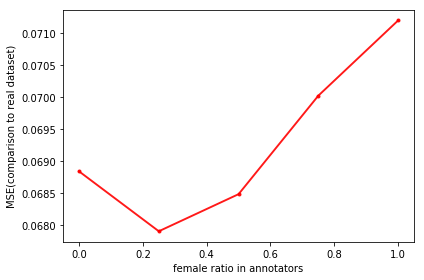

In [16]:
x = [0, 0.25, 0.5, 0.75, 1]
plt.plot(x, mse_gt, marker='.', color='r', linewidth=1.9, alpha=0.9)
plt.xlabel('female ratio in annotators')
plt.ylabel('MSE(comparison to real dataset)')
plt.tight_layout()
plt.savefig('images/mse_to_gt.png', dpi=200)

The model trained on the female0.25 dataset has the lowest MSE, since the ratio of female annotators for the original dataset is close to 1/3 and the female0.25 is most similar to the original dataset where the real labels come from.

### Relative MSE compared to balanced dataset
Since the male to female ratio is close to 0.5 in real world, a balanced dataset would be annotated by workers whose female ratio is 0.5. Thus, I use the predictions from the model which was trained on the female0.5 dataset as the new labels to calculate the relative MSE for other four models.

In [17]:
y_rel_real = predictions['female0.5']['prediction']
mse_rel = []
for r in ratios:
    key = 'female'+r
    df = predictions[key]
    y_pred = df['prediction']
    mse = mean_squared_error(y_rel_real, y_pred)
    mse_rel.append(mse)

The MSEs are then plotted versus the ratio of female annotators.

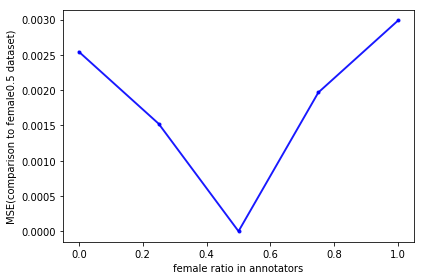

In [18]:
x = [0, 0.25, 0.5, 0.75, 1]
plt.plot(x, mse_rel, marker='.', color='b', linewidth=1.9, alpha=0.9)
plt.xlabel('female ratio in annotators')
plt.ylabel('MSE(comparison to female0.5 dataset)')
plt.tight_layout()
plt.savefig('images/mse_to_0.5.png', dpi=200)

As expected, the MSEs are symmetrical relative to the female0.5 dataset. This phenomenon indicates that more or fewer female annotators will both affect the model predictions.

### Prediction residuals analysis
The MSEs indicate the overall model performance since it is the accumulated errors of all samples. I also would like to explore the errors at the sample level. Thus, the residual of each sample indicates the difference between the prediction and the new label from female0.5 dataset.

In [19]:
y_rel_real = np.array(predictions['female0.5']['prediction'])
residuals = pd.DataFrame(columns=['female0', 'female0.25', 'female0.75', 'female1'])
for r in ratios:
    if r == '0.5':
        continue
    key = 'female'+r
    df = predictions[key]
    y_pred = np.array(df['prediction'])
    residuals[key] = y_pred-y_rel_real
residuals = residuals.reset_index(drop=True)

Boxplots are then created to show the distribution of residuals of other four models.

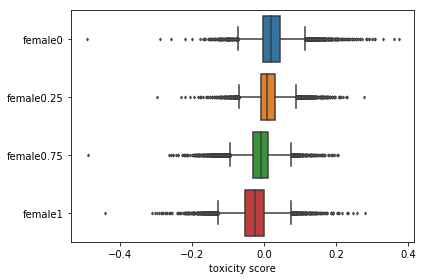

In [20]:
flierprops = dict(markerfacecolor='0.75', markersize=2,
              linestyle='none')
ax = sns.boxplot(data=residuals, orient='h', flierprops=flierprops)
ax.set(xlabel='toxicity score')
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('images/distribution.png', dpi=200)

The distribution of residuals is shifted to be more negative when ratio of female annotators becomes larger. The mean residuals are quite different. So I performed a linear regression test to analyze the differences statistically.

In [21]:
long_df = pd.melt(residuals, var_name = 'ratio', value_name='tox_score')
long_df['ratio'] = pd.to_numeric(long_df['ratio'].str.replace('female',''))
tox_table = ols('tox_score ~ ratio', data=long_df).fit()
print(tox_table.summary())

                            OLS Regression Results                            
Dep. Variable:              tox_score   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                 1.355e+04
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:38:53   Log-Likelihood:             1.1017e+05
No. Observations:               63876   AIC:                        -2.203e+05
Df Residuals:                   63874   BIC:                        -2.203e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0238      0.000     86.622      0.0

The p value for the resulting F-statistic is close to 0, indicating that the mean residuals of these datasets are significantly different. There is a perfect linear relationship between prediction residuals and the ratio of female annotators, since p values for both intercept of the coefficient are 0.

## Conclusion
Female annotators tend to give negative toxicity scores (more toxic) to comments, resulting in biased training set. This bias is able to be transfered through the machine learning process. LSTM models trained on dataset with different ratio of female annotators yield different predictions on comment toxicity. Even unseen comments will be wrongly labeled if the machine learning model was trained on a biased dataset.

## Discussion

Although the result of statistical test is convincing, there are still several caveats that may raise concerns on the result. To mimic the real case scenario in which the ratio of female annotators for a single comment is not controlled no matter what the overall female ratio for the dataset is, I simply remove annotations made by crowdworkers that were not included in a specific subset. However, this leaves inconsistent number of annotations for each comment. In the original dataset, each comment was annotated by ten workers, while in my analysis, the number of annotators for each comment may be different. This may be the reason why the relative MSE for female 0.25 dataset is slightly lower than that of the female 0.75 dataset. Further studies on this topic should not ignore this phenomenon and consider keeping the number of annotations for each comment to be consistent.

Despite the caveat discussed above, this study still provided some implications on human-centered data science. Since humans are complicated, human activities involved in all steps in a machine learning application should be assessed carefully. Specifically, in the dataset preparation step, annotators should be carefully selected as any aspects of demographics of annotators could possibly affect the output.